# Settings

In [135]:
save_preprocessed_data = True
save_RMSE_comaprison_results = True

cycles = 30 # Number of models used for evaluation
training_iterations = 150 # Default 150, optimal iteration count may change if model is modified
folds = 7 # Number of folds in cross validation

# Imports

In [136]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
import gpytorch
from sklearn.model_selection import KFold
from math_functions import mean_squared_error, root_mean_squared_error, denoise_and_norm
from sklearn.metrics import r2_score
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preprocessing

#### Sample Information

In [137]:
file_path = 'data/data_all_no0_only_important.csv'
sample_info = pd.read_csv(file_path, dtype={'Sample name': str, 'Irradiation': int, 'ET_1AU': float, 'group': int})

print(sample_info.dtypes, '\n')
sample_info

Sample name     object
Irradiation      int64
ET_1AU         float64
group            int64
dtype: object 



,Sample name,Irradiation,ET_1AU,group
0,PO_TXH_007,10,3.382378e+08,8
1,PO_TXH_008,10,6.764756e+08,8
2,PO_TXH_081_CP1,10,3.382378e+08,8
3,PO_TXH_081_CP2,10,6.764756e+08,8
4,RB_LE4OLV,10,7.610350e+08,8
...,...,...,...,...
204,OC_LP_A2_3,3,2.361833e+02,2
205,OC_LP_A3_3,3,5.992057e+02,2
206,MJL_OLV_1,9,1.001362e+03,3
207,MJL_OLV_2,9,3.538145e+03,3


#### Load Wavelength and Reflectance

In [138]:
extract_path = 'data/reflectance_data'

too_large_first_wavelength = ['MJL_OLV_1', 'MJL_OLV_2', 'MJL_OLV_3']# These have too large first wavelength
discarded_samples = ['KC_OL_lm_12', 'KC_OL_lvn_12', 'RB_LE3CPX', 'KC_OPX_lvn_11', 'KC_OPX_lm_11', 'TJ_OPX_1'] # Discarded because exposure times were unrealisticly high
unwanted_samples = too_large_first_wavelength + discarded_samples

# Initialize empty dictionaries to hold data for W and R
w_data = {}
r_data = {}

# Iterate through the extracted files and process CSV files
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path, header=None)

            # Extract the filename without extension to use as column header
            file_name = file.split('.')[0]
            if file_name in sample_info['Sample name'].values and file_name not in unwanted_samples:
                df.columns = df.iloc[1]
                df = df[2:].astype(float)

                wavelengths = df["W"].to_numpy() * 1000
                reflectances = df["R"].to_numpy()

                w_data[file_name] = wavelengths
                r_data[file_name] = reflectances

#### Preprocess Wavelength Data

In [139]:
max_first_wavelength = float('-inf')
for key, value in w_data.items():
    if value[0] > max_first_wavelength:
        max_first_wavelength = value[0]
print(max_first_wavelength)

min_last_wavelength = float('inf')
for key, value in w_data.items():
    if value[-1] < min_last_wavelength:
        min_last_wavelength = value[-1]
print(min_last_wavelength)

# Convert the dictionaries to DataFrames
w_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in w_data.items()]))

w_df

540.88
2480.84157


,OC_LP_B2_1,KC_OPX_hevn_1,KC_OPX_lm_9,OC_TXH_011_A60,RB_LE4OLV,KC_OL_arvn_5,OWN_OL4_EN1_1,MY_OL_30,XT_TXH_030_P2,KC_OPX_lm_8,...,KC_OPX_lvn_1,KC_OPX_lvn_10,OC_TXH_013_P05,KC_OPX_hevn_3,KC_OL_hm_2,OC_LP_A3_1,KC_OPX_arvn_5,RB_LE2CPX,KC_OL_arm_1,OC_LP_A2_2
0,250.0,540.88,500.12,300.0,250.0,540.88,496.605913,255.855137,280.0,500.12,...,450.10,450.10,250.0,540.88,500.12,250.0,540.88,250.0,500.12,250.0
1,255.0,541.33,500.31,305.0,251.0,541.33,498.919256,258.242041,285.0,500.31,...,450.26,450.26,255.0,541.33,500.31,255.0,541.33,251.0,500.31,255.0
2,260.0,541.79,500.50,310.0,252.0,541.79,500.461484,261.023115,290.0,500.50,...,450.42,450.42,260.0,541.79,500.50,260.0,541.79,252.0,500.50,260.0
3,265.0,542.24,500.70,315.0,253.0,542.24,502.260751,263.815131,295.0,500.70,...,450.57,450.57,265.0,542.24,500.70,265.0,542.24,253.0,500.70,265.0
4,270.0,542.69,500.89,320.0,254.0,542.69,503.288903,266.194741,300.0,500.89,...,450.73,450.73,270.0,542.69,500.89,270.0,542.69,254.0,500.89,270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2494.10,2494.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2495.30,2495.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2496.50,2496.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2497.70,2497.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Preprocess Reflectance Data

In [140]:
r_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in r_data.items()]))

r_df

,OC_LP_B2_1,KC_OPX_hevn_1,KC_OPX_lm_9,OC_TXH_011_A60,RB_LE4OLV,KC_OL_arvn_5,OWN_OL4_EN1_1,MY_OL_30,XT_TXH_030_P2,KC_OPX_lm_8,...,KC_OPX_lvn_1,KC_OPX_lvn_10,OC_TXH_013_P05,KC_OPX_hevn_3,KC_OL_hm_2,OC_LP_A3_1,KC_OPX_arvn_5,RB_LE2CPX,KC_OL_arm_1,OC_LP_A2_2
0,0.091267,0.30316,0.17514,0.08142,0.102687,0.69376,0.222230,0.078070,0.19662,0.18813,...,0.29841,0.10807,0.087242,0.29999,0.66890,0.073795,0.30564,0.139433,0.45412,0.068925
1,0.095063,0.30342,0.15834,0.08278,0.102185,0.69462,0.222707,0.079495,0.14896,0.18181,...,0.29947,0.10395,0.088632,0.30073,0.66179,0.075704,0.30569,0.138631,0.44680,0.070946
2,0.099236,0.30346,0.15316,0.08263,0.102471,0.69529,0.223281,0.080919,0.13586,0.16909,...,0.29177,0.10738,0.088888,0.30058,0.66537,0.077820,0.30536,0.138315,0.44301,0.073034
3,0.103076,0.30354,0.15552,0.08353,0.102007,0.69547,0.223663,0.083058,0.13219,0.16247,...,0.28526,0.11490,0.087427,0.30090,0.66944,0.079724,0.30506,0.138342,0.43171,0.074928
4,0.107064,0.30343,0.15903,0.08438,0.101547,0.69554,0.224141,0.084007,0.13455,0.16843,...,0.28488,0.13047,0.088377,0.30071,0.66752,0.081352,0.30471,0.137929,0.43110,0.076659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.54237,0.43920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.54303,0.43950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.54355,0.43975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.54356,0.43966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Interpolate and Normalize Data

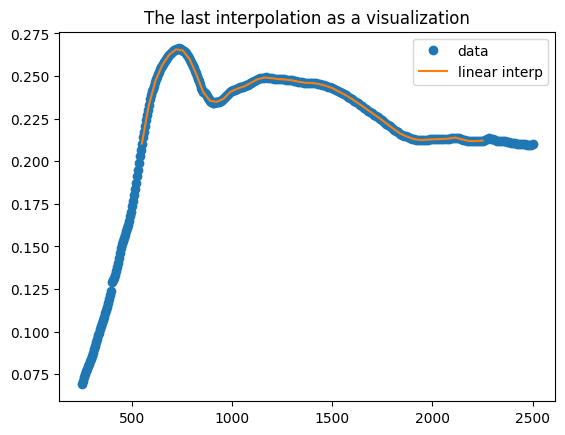

,OC_LP_B2_1,KC_OPX_hevn_1,KC_OPX_lm_9,OC_TXH_011_A60,RB_LE4OLV,KC_OL_arvn_5,OWN_OL4_EN1_1,MY_OL_30,XT_TXH_030_P2,KC_OPX_lm_8,...,KC_OPX_lvn_1,KC_OPX_lvn_10,OC_TXH_013_P05,KC_OPX_hevn_3,KC_OL_hm_2,OC_LP_A3_1,KC_OPX_arvn_5,RB_LE2CPX,KC_OL_arm_1,OC_LP_A2_2
550.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
584.0,1.025818,1.023912,1.085563,1.038690,1.048641,1.012260,1.037647,1.063113,1.028520,1.101411,...,1.050305,1.090798,1.017611,1.025000,1.006495,1.088583,1.030655,1.035233,1.038322,1.105729
618.0,1.041532,1.056567,1.172919,1.068086,1.077656,1.007257,1.074555,1.109795,1.031543,1.182591,...,1.083221,1.163220,1.033550,1.061388,1.001083,1.151232,1.071262,1.065463,1.056541,1.175916
652.0,1.056156,1.101019,1.254283,1.096362,1.110248,1.008834,1.107209,1.143272,1.046723,1.254749,...,1.119670,1.229345,1.051170,1.110001,1.007799,1.191792,1.102640,1.092927,1.079361,1.219676
686.0,1.065866,1.144549,1.320872,1.113485,1.146285,1.009464,1.139044,1.185546,1.071987,1.329229,...,1.161474,1.286154,1.065420,1.147666,1.010311,1.219460,1.153756,1.119006,1.098171,1.247651
720.0,1.070456,1.187161,1.377180,1.115344,1.146664,0.983658,1.165315,1.198987,1.082094,1.380829,...,1.199106,1.328543,1.079248,1.188370,0.984608,1.236806,1.205637,1.159498,1.097729,1.263192
754.0,1.061514,1.214569,1.357387,1.100633,1.138979,0.940578,1.186650,1.194375,1.043446,1.365064,...,1.193812,1.311839,1.084272,1.213442,0.937861,1.236653,1.231927,1.189243,1.071949,1.260106
788.0,1.034156,1.152679,1.222129,1.060663,1.103010,0.890738,1.195784,1.178256,0.941096,1.239008,...,1.104968,1.193353,1.074962,1.145232,0.884774,1.217217,1.178402,1.230141,1.040170,1.236116
822.0,0.990079,1.017062,1.015402,1.000615,1.083838,0.850030,1.195788,1.154509,0.790606,1.032367,...,0.933553,1.005976,1.056105,1.008453,0.843718,1.178752,1.042542,1.264141,1.011377,1.193089
856.0,0.938160,0.877875,0.816616,0.935963,1.066920,0.826343,1.192161,1.158415,0.654814,0.838159,...,0.777054,0.819551,1.028452,0.872187,0.817458,1.122173,0.900563,1.257603,0.997408,1.143957


In [141]:
use_denoising_and_normalization = True
only_normalization = False
number_of_wavelengths = 51

# interpolation_wavelengths = np.linspace(541., 2424., number_of_wavelengths)
interpolation_wavelengths = np.linspace(550., 2250., number_of_wavelengths)
interpolation_dict = {}

for i in range(len(w_df.columns)):
	wavelengths = w_df.iloc[:, i].to_numpy()
	unique_wavelengths, unique_indices = np.unique(wavelengths, return_index=True)

	reflectances = r_df.iloc[:, i].to_numpy()
	unique_reflectances = reflectances[unique_indices]

	interpolation = np.interp(interpolation_wavelengths, unique_wavelengths, unique_reflectances)

	if use_denoising_and_normalization:
		denoised_normalized_data = denoise_and_norm(interpolation, interpolation_wavelengths, denoising=True, normalising=True)
		denoised_normalized_data = denoised_normalized_data.flatten()
		interpolation_dict[w_df.columns[i]] = denoised_normalized_data
		normalized_interpolation = interpolation / interpolation[0]
		# print(np.mean((denoised_normalized_data - normalized_interpolation) ** 2)) # Similarity of own and Davids methods
		# print(np.array_equal(denoised_normalized_data, normalized_interpolation))
	elif only_normalization:
		normalized_interpolation = interpolation / interpolation[0]
		interpolation_dict[w_df.columns[i]] = normalized_interpolation
	else:
		interpolation_dict[w_df.columns[i]] = interpolation

interpolation_df = pd.DataFrame(interpolation_dict, index=interpolation_wavelengths)
#interpolation_df = interpolation_df.transpose()

plt.plot(unique_wavelengths, unique_reflectances, 'o', label='data')
plt.plot(interpolation_wavelengths, interpolation, '-', label='linear interp')
plt.legend(loc='best')
plt.title('The last interpolation as a visualization')
plt.show()

interpolation_df

#### Combine Sample Info and Reflectance Data

In [142]:
reflectance_data_transposed = interpolation_df.T
reflectance_data_transposed.reset_index(inplace=True)
reflectance_data_transposed.rename(columns={'index': 'Sample name'}, inplace=True)

# Merge sample_info with the transposed reflectance_data
merged_data = pd.merge(sample_info, reflectance_data_transposed, on='Sample name')
merged_data

,Sample name,Irradiation,ET_1AU,group,550.0,584.0,618.0,652.0,686.0,720.0,...,1944.0,1978.0,2012.0,2046.0,2080.0,2114.0,2148.0,2182.0,2216.0,2250.0
0,PO_TXH_007,10,3.382378e+08,8,1.0,1.007878,0.988193,0.982036,0.981669,0.948793,...,1.191461,1.190995,1.194271,1.193846,1.195411,1.199186,1.198067,1.197574,1.200647,1.202141
1,PO_TXH_008,10,6.764756e+08,8,1.0,1.009224,0.993181,0.989376,0.990417,0.958965,...,1.216220,1.214997,1.216873,1.218533,1.218845,1.223721,1.223077,1.223112,1.226167,1.228659
2,PO_TXH_081_CP1,10,3.382378e+08,8,1.0,1.024809,1.028070,1.038039,1.045095,1.016770,...,1.311319,1.312123,1.317130,1.318421,1.321785,1.323010,1.320729,1.323559,1.321747,1.318766
3,PO_TXH_081_CP2,10,6.764756e+08,8,1.0,1.045083,1.057163,1.080219,1.080057,1.069199,...,1.510710,1.515629,1.522968,1.524898,1.527924,1.532406,1.532107,1.532269,1.540105,1.532981
4,RB_LE4OLV,10,7.610350e+08,8,1.0,1.048641,1.077656,1.110248,1.146285,1.146664,...,2.236935,2.278695,2.313884,2.339006,2.351942,2.370500,2.391162,2.417522,2.421736,2.440278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,OC_LP_A2_2,3,2.361833e+02,2,1.0,1.105729,1.175916,1.219676,1.247651,1.263192,...,1.010004,1.011335,1.012174,1.012669,1.014064,1.016990,1.011704,1.007090,1.007014,1.008625
196,OC_LP_A3_2,3,5.992057e+02,2,1.0,1.097169,1.163768,1.207710,1.237273,1.255537,...,1.048189,1.050554,1.051604,1.053263,1.054960,1.058765,1.052953,1.048257,1.050416,1.053120
197,OC_LP_A1_3,3,9.491069e+01,1,1.0,1.098777,1.162888,1.200541,1.222890,1.234319,...,0.949880,0.950406,0.951033,0.949815,0.951064,0.950365,0.941783,0.940278,0.939529,0.940415
198,OC_LP_A2_3,3,2.361833e+02,2,1.0,1.101528,1.169834,1.211440,1.236943,1.251505,...,0.997011,0.998404,0.999469,0.998505,1.000379,0.999339,0.990166,0.988745,0.989049,0.990642


#### Save the Data

In [143]:
if save_preprocessed_data:
	merged_data.to_csv('data/combined_data_550-2250.csv', index=False)

#### Prepare the Data for the Model

In [144]:
data = pd.read_csv('data/combined_data_550-2250.csv')
data['ET_1AU'].describe()

count    2.000000e+02
mean     6.074343e+08
std      1.012104e+09
min      4.373764e-02
25%      6.675746e+02
50%      3.089238e+08
75%      8.054287e+08
max      6.764756e+09
Name: ET_1AU, dtype: float64

In [ ]:
irradiation_types = {
    1: "I_H_OL",
    2: "I_H_PX",
    3: "I_H_M",
    4: "I_Ar_OL",
    5: "I_Ar_PX",
    6: "I_Ar_M",
    7: "I_He_OL",
    8: "I_He_PX",
    9: "I_He_M",
    10: "L_OL",
    11: "L_PX",
    12: "L_M"
}

In [145]:
counts = data['Irradiation'].value_counts()
print(counts)
data['ET_1AU'] = np.log10(data['ET_1AU']+1) # Scale the target to log10

'''
Irradiation type combinations
Hydrogen + laser on only olivine = 1, 10
Hydrogen + laser on all minerals = 1, 2, 3, 10, 11, 12
All = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
'''

selected_irradiations = [1, 2, 3, 10, 11, 12] # Which irradiation types are taken into the training dataset

num_of_data_rows = data.shape[0]
print(num_of_data_rows)

data

10    58
12    46
11    24
3     18
1     12
2     10
4      9
5      7
7      6
8      5
6      5
Name: Irradiation, dtype: int64
200


,Sample name,Irradiation,ET_1AU,group,550.0,584.0,618.0,652.0,686.0,720.0,...,1944.0,1978.0,2012.0,2046.0,2080.0,2114.0,2148.0,2182.0,2216.0,2250.0
0,PO_TXH_007,10,8.529222,8,1.0,1.007878,0.988193,0.982036,0.981669,0.948793,...,1.191461,1.190995,1.194271,1.193846,1.195411,1.199186,1.198067,1.197574,1.200647,1.202141
1,PO_TXH_008,10,8.830252,8,1.0,1.009224,0.993181,0.989376,0.990417,0.958965,...,1.216220,1.214997,1.216873,1.218533,1.218845,1.223721,1.223077,1.223112,1.226167,1.228659
2,PO_TXH_081_CP1,10,8.529222,8,1.0,1.024809,1.028070,1.038039,1.045095,1.016770,...,1.311319,1.312123,1.317130,1.318421,1.321785,1.323010,1.320729,1.323559,1.321747,1.318766
3,PO_TXH_081_CP2,10,8.830252,8,1.0,1.045083,1.057163,1.080219,1.080057,1.069199,...,1.510710,1.515629,1.522968,1.524898,1.527924,1.532406,1.532107,1.532269,1.540105,1.532981
4,RB_LE4OLV,10,8.881405,8,1.0,1.048641,1.077656,1.110248,1.146285,1.146664,...,2.236935,2.278695,2.313884,2.339006,2.351942,2.370500,2.391162,2.417522,2.421736,2.440278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,OC_LP_A2_2,3,2.375084,2,1.0,1.105729,1.175916,1.219676,1.247651,1.263192,...,1.010004,1.011335,1.012174,1.012669,1.014064,1.016990,1.011704,1.007090,1.007014,1.008625
196,OC_LP_A3_2,3,2.778300,2,1.0,1.097169,1.163768,1.207710,1.237273,1.255537,...,1.048189,1.050554,1.051604,1.053263,1.054960,1.058765,1.052953,1.048257,1.050416,1.053120
197,OC_LP_A1_3,3,1.981867,1,1.0,1.098777,1.162888,1.200541,1.222890,1.234319,...,0.949880,0.950406,0.951033,0.949815,0.951064,0.950365,0.941783,0.940278,0.939529,0.940415
198,OC_LP_A2_3,3,2.375084,2,1.0,1.101528,1.169834,1.211440,1.236943,1.251505,...,0.997011,0.998404,0.999469,0.998505,1.000379,0.999339,0.990166,0.988745,0.989049,0.990642


In [146]:
X_task_sets = [] # list[ np[task 1 X], np[task 2 X], [...], ...]
y_task_sets = [] # list[ np[task 1 y], np[task 2 y], [...], ...]

# Save indices for RMSE calculations. This keeps track of the asteroid IDs for GP model tasks
sample_id_task_sets = [] # list[ np[task 1 indices], np[task 2 indices], [...], ...]

# Separate different irradiation types into tasks. (Tasks are the different GP model categories for different irradiation types)
for task in selected_irradiations:
	task_set = data[data['Irradiation'].isin([task])].copy()
	if len(task_set)==0:
		continue
	task_indices = task_set.index.to_numpy()
	sample_id_task_sets.append(task_indices)
	task_set.drop(['Sample name', 'Irradiation', 'group'], axis=1, inplace=True)
	X = task_set.drop('ET_1AU', axis=1).values
	y = task_set['ET_1AU'].values
	X_task_sets.append(X)
	y_task_sets.append(y)

# Number of data for different tasks
number_of_total_data_points = 0
for task in y_task_sets:
	number_of_total_data_points += len(task)
	print(len(task))
print(f'Total {number_of_total_data_points}')

12
10
18
58
24
46
Total 168


In [147]:
data_dim = X.shape[-1] # Number of considered wavelengths
print(data_dim)

51


# GP Model

#### Feature Extractor

In [149]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding='same') # Convolutional layer
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2) # reduces the dimensionality
        self.fc1 = torch.nn.Linear((data_dim // 2) * 16, data_dim) # Fully connected layer, reduces dimensionality

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension: (batch_size, 1, data_dim)
        x = F.relu(self.conv1(x))  # Apply convolution, batch norm, and ReLU
        x = self.pool(x)  # Apply max pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor: (batch_size, 16 * (data_dim // 2))
        x = self.fc1(x)  # Apply linear layer: (batch_size, data_dim)
        return x

#### model training

In [150]:
kf = KFold(n_splits=folds, shuffle=True)

results_per_id = np.full((num_of_data_rows, cycles), np.nan) # Array for prediction results
true_values_per_id = np.full((num_of_data_rows, 1), np.nan) # True target values

In [151]:
for cycle in range(cycles):
	fold = 1

	# Keep track of indices for RMSE calculations
	data_fold_indexes = [] # [[(train_index, test_index), (train_index, test_index), ...], [...], [...], [...], [...]] = for tasks, for kfold_split
	for task in range(len(X_task_sets)):
		data_fold_indexes.append([])
		for train_index, test_index in kf.split(X_task_sets[task]):
			data_fold_indexes[-1].append((train_index, test_index))

	for data_fold in range(folds): # Cross validation
		print(f'Cycle {cycle+1}/{cycles}')
		print(f'Fold {fold}/{folds}')
		fold += 1

		X_train_list = []
		X_test_list = []
		y_train_list = []
		y_test_list = [] # list[ tensor[y, y, ...], tensor[...], ...]
		train_i_task_list = []
		test_i_task_list = []

		original_indices_of_test_folds = [] # list[ list[id, id, ...], list[...], ...] # Keep track of data IDs

		# Process data for each task
		for task in range(len(X_task_sets)):
			train_index, test_index = data_fold_indexes[task][data_fold]

			X_train, X_test = X_task_sets[task][train_index], X_task_sets[task][test_index]
			y_train, y_test = y_task_sets[task][train_index], y_task_sets[task][test_index]

			original_indices_of_test_fold = sample_id_task_sets[task][test_index]

			X_train = torch.tensor(X_train, dtype=torch.float32)
			X_test = torch.tensor(X_test, dtype=torch.float32)
			y_train = torch.tensor(y_train, dtype=torch.float32)
			y_test = torch.tensor(y_test, dtype=torch.float32)

			X_train_list.append(X_train)
			X_test_list.append(X_test)
			y_train_list.append(y_train)
			y_test_list.append(y_test)
			train_i_task_list.append(torch.full((X_train.shape[0],1), dtype=torch.long, fill_value=task))
			test_i_task_list.append(torch.full((X_test.shape[0],1), dtype=torch.long, fill_value=task))

			original_indices_of_test_folds.append(original_indices_of_test_fold)

		full_X_train = torch.cat(X_train_list)
		full_train_i = torch.cat(train_i_task_list)
		full_y_train = torch.cat(y_train_list)

		# print(full_X_train)
		# print(full_train_i)
		# print(full_y_train)

		full_X_test = torch.cat(X_test_list)
		full_test_i = torch.cat(test_i_task_list)
		full_y_test = torch.cat(y_test_list) # tensor[y, y, y, ...]
		
		full_original_indices_of_test_folds = [] # list[id, id, id, ...]
		for sublist in original_indices_of_test_folds:
			full_original_indices_of_test_folds.extend(sublist)
		# print(len(full_y_test), len(full_original_indices_of_test_folds))
		# print(full_y_test)
		# print(full_original_indices_of_test_folds)

		feature_extractor = FeatureExtractor()

		# The model itself
		class MultitaskGPModel(gpytorch.models.ExactGP):
			def __init__(self, train_x, train_y, likelihood):
				super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
				self.mean_module = gpytorch.means.ConstantMean() # Mean function
				self.covar_module = gpytorch.kernels.keops.MaternKernel(nu=0.5) # Covariance function
				self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=len(X_task_sets), rank=3) # Task covariance function
				self.feature_extractor = feature_extractor
				self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.) # Scaling/normalization

			def forward(self, x, i):
				extracted_features = self.feature_extractor(x)
	
				# Ensure extracted features are scaled appropriately
				extracted_features = self.scale_to_bounds(extracted_features)

				mean_x = self.mean_module(extracted_features)

				# Get input-input covariance
				covar_x = self.covar_module(extracted_features)
				# Get task-task covariance
				covar_i = self.task_covar_module(i)
				# Multiply the two together to get the covariance we want
				covar = covar_x.mul(covar_i)

				return gpytorch.distributions.MultivariateNormal(mean_x, covar)

			
		likelihood = gpytorch.likelihoods.GaussianLikelihood()
		model = MultitaskGPModel((full_X_train, full_train_i), full_y_train, likelihood) # full_train_i tells the model which task each data point belongs

		model.train()
		likelihood.train()

		optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

		# "Loss" for GPs - the marginal log likelihood
		mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

		# Training loop
		counter = -1
		iterator = tqdm.notebook.tqdm(range(training_iterations))
		for i in iterator:
			counter += 1
			with gpytorch.settings.cholesky_max_tries(5):
				optimizer.zero_grad()
				output = model(full_X_train, full_train_i)
				loss = -mll(output, full_y_train)
				loss.backward()
				iterator.set_postfix(loss=loss.item())
				optimizer.step()

		# Evaluation
		model.eval()
		likelihood.eval()
		with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
			y_preds = likelihood(model(full_X_test, full_test_i))
			mean = y_preds.mean # The means are used as prediction values
			lower, upper = y_preds.confidence_region() # GP model's own confidence bounds (not using these at the moment)

		y_test_np = full_y_test.numpy()
		mean = mean.numpy()
		lower = lower.numpy()
		upper = upper.numpy()

		# Append the results
		for i, y_test_point in enumerate(y_test_np):
			results_per_id[full_original_indices_of_test_folds[i], cycle] = mean[i]
			if cycle == 0:
				true_values_per_id[full_original_indices_of_test_folds[i], 0] = y_test_point

		unscaled_mean = 10 ** mean
		unscaled_y_test = 10 ** y_test_np

Cycle 1/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 4/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 4/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 4/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 4/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 4/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 4/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 4/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 5/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 5/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 5/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 5/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 5/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 5/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 5/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 6/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 6/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 6/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 6/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 6/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 6/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 6/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 7/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 7/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 7/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 7/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 7/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 7/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 7/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 8/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 8/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 8/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 8/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 8/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 8/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 8/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 9/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 9/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 9/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 9/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 9/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 9/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 9/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 10/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 10/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 10/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 10/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 10/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 10/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 10/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 11/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 11/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 11/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 11/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 11/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 11/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 11/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 12/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 12/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 12/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 12/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 12/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 12/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 12/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 13/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 13/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 13/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 13/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 13/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 13/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 13/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 14/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 14/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 14/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 14/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 14/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 14/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 14/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 15/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 15/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 15/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 15/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 15/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 15/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 15/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 16/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 16/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 16/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 16/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 16/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 16/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 16/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 17/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 17/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 17/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 17/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 17/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 17/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 17/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 18/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 18/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 18/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 18/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 18/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 18/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 18/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 19/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 19/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 19/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 19/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 19/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 19/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 19/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 20/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 20/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 20/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 20/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 20/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 20/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 20/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 21/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 21/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 21/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 21/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 21/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 21/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 21/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 22/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 22/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 22/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 22/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 22/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 22/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 22/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 23/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 23/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 23/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 23/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 23/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 23/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 23/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 24/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 24/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 24/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 24/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 24/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 24/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 24/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 25/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 25/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 25/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 25/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 25/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 25/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 25/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 26/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 26/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 26/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 26/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 26/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 26/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 26/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 27/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 27/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 27/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 27/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 27/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 27/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 27/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 28/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 28/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 28/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 28/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 28/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 28/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 28/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 29/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 29/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 29/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 29/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 29/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 29/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 29/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 30/30
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 30/30
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 30/30
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 30/30
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 30/30
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 30/30
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 30/30
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

#### Process Results

In [152]:
results_per_id_rows_with_nan = np.isnan(results_per_id).any(axis=1)
results_per_id = results_per_id[~results_per_id_rows_with_nan]

print(len(results_per_id))

results_per_id

168


array([[8.80352783, 8.79360867, 8.78492928, ..., 8.79239082, 8.45880795,
        8.76323414],
       [8.53610992, 8.51399136, 8.5326376 , ..., 8.49585915, 8.48006344,
        8.53587914],
       [8.50170135, 8.296978  , 8.59698868, ..., 8.41422462, 8.75554943,
        8.02434349],
       ...,
       [2.14441299, 2.08199954, 2.11986351, ..., 2.23449874, 2.10744619,
        2.09742832],
       [2.27768683, 2.30882931, 2.41792369, ..., 2.40139818, 2.33914161,
        2.40404248],
       [2.45844793, 2.48325348, 2.40250015, ..., 2.50176311, 2.52419162,
        2.4471333 ]])

In [153]:
true_values_per_id_rows_with_nan = np.isnan(true_values_per_id).any(axis=1)
true_values_per_id = true_values_per_id[~true_values_per_id_rows_with_nan]
true_values_per_id = true_values_per_id.flatten()

print(len(true_values_per_id))
true_values_per_id

168


array([8.52922249, 8.83025169, 8.52922249, 8.83025169, 8.88140488,
       9.16604424, 0.15757053, 0.73027861, 1.65067315, 2.34180689,
       2.64184713, 0.01859135, 0.15757053, 0.73027861, 1.65067315,
       1.94682193, 2.34180689, 2.64184713, 7.68049002, 7.83025217,
       8.02982426, 8.11279869, 8.27611542, 8.46707439, 8.62613201,
       8.81925678, 8.93576241, 9.22819233, 9.42224407, 7.68049002,
       7.83025217, 8.02982426, 8.11279869, 8.27611542, 8.46707439,
       8.62613201, 8.81925678, 8.93576241, 9.22819233, 9.42224407,
       8.92716217, 8.83025169, 9.52922249, 9.83025169, 8.52922249,
       8.83025169, 9.52922249, 9.14901066, 9.45004082, 9.62613201,
       8.52922249, 8.83025169, 7.73334217, 8.03437233, 8.33540249,
       8.51149368, 8.63643169, 8.81252289, 8.93746185, 9.03437233,
       8.77617168, 8.77617168, 8.77617168, 8.45864105, 8.75967121,
       8.93576241, 9.06070137, 9.15761089, 9.15761089, 9.55555153,
       9.20591545, 9.08350945, 7.50119352, 0.73027861, 1.65067

In [154]:
# The averages of the predictions are calculated from the original data scale.
original_scale_results_per_id = 10 ** results_per_id
original_scale_average_results_per_id = np.mean(original_scale_results_per_id, axis=1)

original_scale_average_results_per_id

array([5.51661088e+08, 3.23320839e+08, 3.03374657e+08, 3.65030800e+08,
       2.08691253e+09, 9.35444044e+08, 1.65087543e+01, 2.07067804e+00,
       8.61287772e+00, 4.22469257e+02, 3.98985046e+02, 1.87085813e+00,
       1.76245694e+00, 2.08940656e+01, 5.31580524e+00, 2.62411222e+02,
       2.16062184e+02, 2.82433459e+02, 6.83218206e+07, 1.07229916e+08,
       1.28696651e+08, 1.00089297e+08, 1.77493513e+08, 3.28409328e+08,
       5.11990439e+08, 7.34831273e+08, 9.36537725e+08, 1.87752649e+09,
       2.38100009e+09, 5.68004082e+07, 5.97725465e+07, 9.12660206e+07,
       1.25960804e+08, 2.01804764e+08, 2.74068154e+08, 4.46179425e+08,
       6.92295590e+08, 8.43700350e+08, 1.17873779e+09, 1.96549726e+09,
       1.18097715e+09, 7.52816682e+08, 3.37479982e+09, 2.90573971e+09,
       3.15892025e+08, 6.33821398e+08, 3.22060009e+09, 9.85565394e+08,
       3.10037256e+09, 2.10909221e+09, 2.46015716e+08, 6.48715649e+08,
       1.05596615e+08, 1.13269603e+08, 2.21893183e+08, 3.39180167e+08,
      

In [155]:
log_scale_average_results_per_id = np.log10(original_scale_average_results_per_id)
log_scale_average_results_per_id

array([8.74167235, 8.5096337 , 8.4819793 , 8.56232951, 9.31950425,
       8.97101781, 1.2177143 , 0.31611258, 0.93514828, 2.62579511,
       2.60095662, 0.27204085, 0.24611852, 1.32002295, 0.72556906,
       2.4189824 , 2.33457876, 2.45091615, 7.83455943, 8.03031596,
       8.10956724, 8.00038764, 8.24918249, 8.51641548, 8.70926185,
       8.86618763, 8.97152528, 9.27358607, 9.37675941, 7.75435146,
       7.77650176, 7.96030911, 8.10023543, 8.30493141, 8.43785857,
       8.64950954, 8.84029156, 8.92618823, 9.07141721, 9.29347244,
       9.07224149, 8.87668923, 9.52824802, 9.46325671, 8.49953866,
       8.8019669 , 9.5079368 , 8.99368545, 9.49141388, 9.32409557,
       8.39096285, 8.81205437, 8.02365   , 8.05411338, 8.34614396,
       8.53043045, 8.6792053 , 8.86906353, 9.27382059, 9.43520336,
       8.64733674, 8.78298367, 8.8120864 , 8.59268162, 8.67638892,
       9.05827635, 9.21412318, 9.35777647, 8.92098768, 9.05529871,
       8.83822915, 8.75763951, 8.35284078, 0.86844868, 1.72365

# Results

In [156]:
final_results_per_id = pd.DataFrame(columns=['y_true', 'y_pred_average', 'error', 'standard_deviation'])

for i in range(len(true_values_per_id)):
	new_row = pd.DataFrame({
		'y_true': [true_values_per_id[i]],
		'y_pred_average': [log_scale_average_results_per_id[i]],
		'error': [log_scale_average_results_per_id[i] - true_values_per_id[i]],
		'standard_deviation': [np.std(results_per_id[i], ddof=1)]
	})
	final_results_per_id = pd.concat([final_results_per_id, new_row], ignore_index=True)
print(final_results_per_id.shape)
final_results_per_id

(168, 4)


,y_true,y_pred_average,error,standard_deviation
0,8.529222,8.741672,0.212450,0.152179
1,8.830252,8.509634,-0.320618,0.072547
2,8.529222,8.481979,-0.047243,0.150518
3,8.830252,8.562330,-0.267922,0.107739
4,8.881405,9.319504,0.438099,0.054221
...,...,...,...,...
163,2.375084,2.415456,0.040372,0.054960
164,2.778300,2.613395,-0.164905,0.100878
165,1.981867,2.150613,0.168746,0.107367
166,2.375084,2.401982,0.026897,0.071285


In [157]:
gp_RMSE = root_mean_squared_error(final_results_per_id['y_true'], final_results_per_id['y_pred_average'])
gp_R2 = r2_score(final_results_per_id['y_true'], final_results_per_id['y_pred_average'])
print(gp_RMSE, gp_R2)

0.23647163318939382 0.9935404703050071


#### Ensemble model results as a comparison (updated in July 26th 2024)

In [158]:
ensemble_cnn_df = pd.read_excel('data/Ensemble_CNN_Tree_30repeat.xlsx')
ensemble_cnn_df

,Actual,Predicted,Abs_error,STD
0,8.529222,8.287601,-0.241622,0.329885
1,8.830252,8.235695,-0.594557,0.318001
2,8.529222,8.014378,-0.514845,0.213826
3,8.830252,8.368659,-0.461593,0.293570
4,8.881405,9.238439,0.357034,0.181062
...,...,...,...,...
163,2.375084,2.563779,0.188695,0.090683
164,2.778300,2.426000,-0.352300,0.071308
165,1.981867,2.079478,0.097611,0.080304
166,2.375084,2.538110,0.163026,0.100658


In [159]:
ensemble_RMSE = root_mean_squared_error(ensemble_cnn_df['Actual'], ensemble_cnn_df['Predicted'])
ensemble_R2 = r2_score(ensemble_cnn_df['Actual'], ensemble_cnn_df['Predicted'])
print(ensemble_RMSE, ensemble_R2)

0.29831998401621 0.9897196597029486


#### Comparing Results

In [160]:
index_names = ['0-1e2', '1e2-1e3', '1e3-1e4', '1e4-1e5', '1e5-1e6', '1e6-1e7', '1e7-1e8', '1e8-1e9', '1e9-1e10']
column_names = ['number of data points', 'GP RMSE', 'Ensemble RMSE']
results_split = pd.DataFrame(
	columns=column_names,
	index=index_names
)

previous = 1
for i, selection in enumerate([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]):
	selected_rows = final_results_per_id[(final_results_per_id['y_true'] >= np.log10(previous)) & (final_results_per_id['y_true'] < np.log10(selection))]
	results_split.loc[index_names[i], 'number of data points'] = len(selected_rows)
	results_split.loc[index_names[i], 'GP RMSE'] = root_mean_squared_error(selected_rows['y_true'], selected_rows['y_pred_average'])
	
	selected_rows = ensemble_cnn_df[(ensemble_cnn_df['Actual'] >= np.log10(previous)) & (ensemble_cnn_df['Actual'] < np.log10(selection))]
	results_split.loc[index_names[i], 'Ensemble RMSE'] = root_mean_squared_error(selected_rows['Actual'], selected_rows['Predicted'])

	previous = selection
	
results_split

,number of data points,GP RMSE,Ensemble RMSE
0-1e2,20,0.44388,0.451631
1e2-1e3,20,0.174846,0.204203
1e3-1e4,0,NaN,NaN
1e4-1e5,0,NaN,NaN
1e5-1e6,0,NaN,NaN
1e6-1e7,0,NaN,NaN
1e7-1e8,6,0.383338,0.543032
1e8-1e9,88,0.174303,0.241064
1e9-1e10,34,0.194566,0.304601


In [161]:
if save_RMSE_comaprison_results:
	results_split.to_excel(f'results/GP_Ensemble_RMSE_split_comparison.xlsx', index=True)

# Plots

90th percentile
GP 0.36113164352787336
Ensemble 0.4807905626217658

95th percentile
GP 0.4474502146933137
Ensemble 0.5879392841240789


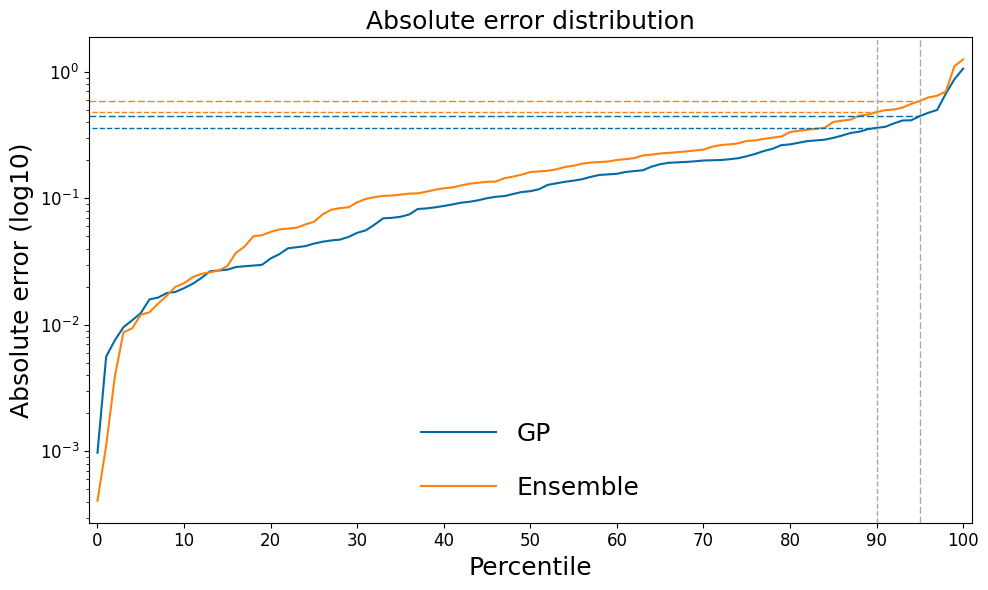

In [162]:
gp_errors = final_results_per_id['error'].to_list()
gp_absolute_errors = [abs(value) for value in gp_errors]
ensemble_cnn_errors = ensemble_cnn_df['Abs_error'].to_list()
ensemble_cnn_absolute_errors = [abs(value) for value in ensemble_cnn_errors]

percentiles = np.arange(0, 101, 1)
gp_error_percentiles = np.percentile(gp_absolute_errors, percentiles)
ensemble_cnn_error_percentiles = np.percentile(ensemble_cnn_absolute_errors, percentiles)

gp_y_at_90th_percentile = gp_error_percentiles[90]
ensemble_y_at_90th_percentile = ensemble_cnn_error_percentiles[90]
gp_y_at_95th_percentile = gp_error_percentiles[95]
ensemble_y_at_95th_percentile = ensemble_cnn_error_percentiles[95]
print(
	f'''90th percentile
GP {gp_y_at_90th_percentile}
Ensemble {ensemble_y_at_90th_percentile}

95th percentile
GP {gp_y_at_95th_percentile}
Ensemble {ensemble_y_at_95th_percentile}'''
)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, gp_error_percentiles, linestyle='-', color='#006BA4', label='GP')
plt.plot(percentiles, ensemble_cnn_error_percentiles, linestyle='-', color='#FF800E', label='Ensemble')
plt.plot([-10, 90], [gp_y_at_90th_percentile, gp_y_at_90th_percentile], color='#006BA4', linestyle='--', linewidth=1)
plt.plot([-10, 90], [ensemble_y_at_90th_percentile, ensemble_y_at_90th_percentile], color='#FF800E', linestyle='--', linewidth=1)
plt.plot([-10, 95], [gp_y_at_95th_percentile, gp_y_at_95th_percentile], color='#006BA4', linestyle=(0, (5, 2)), linewidth=1)
plt.plot([-10, 95], [ensemble_y_at_95th_percentile, ensemble_y_at_95th_percentile], color='#FF800E', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=95, color='#ABABAB', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=90, color='#ABABAB', linestyle='--', linewidth=1)
plt.yscale('log')
plt.title('Absolute error distribution', fontsize=18)
plt.xlabel('Percentile', fontsize=18)
plt.ylabel('Absolute error (log10)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(np.arange(0, 101, 10))  # Setting x-axis values in steps of 10
plt.legend(
	fontsize=18,  # Font size
	loc='lower center',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
plt.xlim((-1.0, 101.0))
plt.tight_layout()
plt.show()

In [163]:
# abolute error percentiles for below and above threshold
threshold = 5 # 10**5 = 100000, log10(100000) = 5
GP_below_threshold = final_results_per_id[final_results_per_id['y_true'] < threshold]
GP_above_threshold = final_results_per_id[final_results_per_id['y_true'] >= threshold]
ensemble_below_threshold = ensemble_cnn_df[ensemble_cnn_df['Actual'] < threshold]
ensemble_above_threshold = ensemble_cnn_df[ensemble_cnn_df['Actual'] >= threshold]

90th percentile
	GP 0.4839188630123324
	Ensemble 0.49488136570283703

95th percentile
	GP 0.7260038305381619
	Ensemble 0.7240127339959903


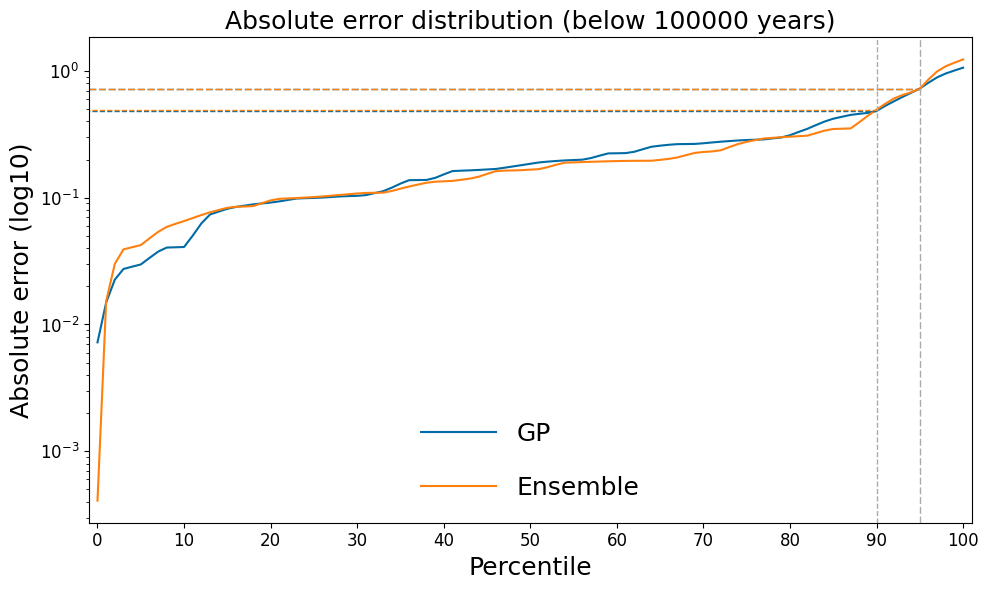

In [164]:
# Below hreshold
gp_errors = GP_below_threshold['error'].to_list()
gp_absolute_errors = [abs(value) for value in gp_errors]
ensemble_cnn_errors = ensemble_below_threshold['Abs_error'].to_list()
ensemble_cnn_absolute_errors = [abs(value) for value in ensemble_cnn_errors]

percentiles = np.arange(0, 101, 1)
gp_error_percentiles = np.percentile(gp_absolute_errors, percentiles)
ensemble_cnn_error_percentiles = np.percentile(ensemble_cnn_absolute_errors, percentiles)

gp_y_at_90th_percentile = gp_error_percentiles[90]
ensemble_y_at_90th_percentile = ensemble_cnn_error_percentiles[90]
gp_y_at_95th_percentile = gp_error_percentiles[95]
ensemble_y_at_95th_percentile = ensemble_cnn_error_percentiles[95]
print(
	f'''90th percentile
	GP {gp_y_at_90th_percentile}
	Ensemble {ensemble_y_at_90th_percentile}

95th percentile
	GP {gp_y_at_95th_percentile}
	Ensemble {ensemble_y_at_95th_percentile}'''
)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, gp_error_percentiles, linestyle='-', color='#006BA4', label='GP')
plt.plot(percentiles, ensemble_cnn_error_percentiles, linestyle='-', color='#FF800E', label='Ensemble')
plt.plot([-10, 90], [gp_y_at_90th_percentile, gp_y_at_90th_percentile], color='#006BA4', linestyle='--', linewidth=1)
plt.plot([-10, 90], [ensemble_y_at_90th_percentile, ensemble_y_at_90th_percentile], color='#FF800E', linestyle='--', linewidth=1)
plt.plot([-10, 95], [gp_y_at_95th_percentile, gp_y_at_95th_percentile], color='#006BA4', linestyle=(0, (5, 2)), linewidth=1)
plt.plot([-10, 95], [ensemble_y_at_95th_percentile, ensemble_y_at_95th_percentile], color='#FF800E', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=95, color='#ABABAB', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=90, color='#ABABAB', linestyle='--', linewidth=1)
plt.yscale('log')
plt.title('Absolute error distribution (below 100000 years)', fontsize=18)
plt.xlabel('Percentile', fontsize=18)
plt.ylabel('Absolute error (log10)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(np.arange(0, 101, 10))
plt.legend(
	fontsize=18,  # Font size
	loc='lower center',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
plt.xlim((-1.0, 101.0))
plt.tight_layout()
plt.show()

90th percentile
	GP 0.33595626821723457
	Ensemble 0.46747136996653194

95th percentile
	GP 0.39151934755763507
	Ensemble 0.5515709798211945


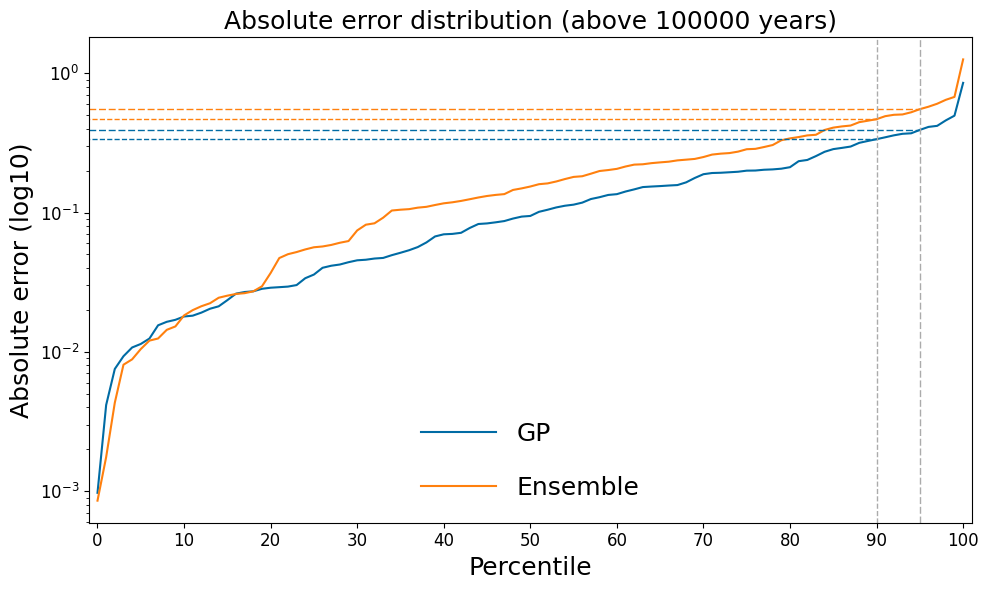

In [165]:
# Above hreshold
gp_errors = GP_above_threshold['error'].to_list()
gp_absolute_errors = [abs(value) for value in gp_errors]
ensemble_cnn_errors = ensemble_above_threshold['Abs_error'].to_list()
ensemble_cnn_absolute_errors = [abs(value) for value in ensemble_cnn_errors]

percentiles = np.arange(0, 101, 1)
gp_error_percentiles = np.percentile(gp_absolute_errors, percentiles)
ensemble_cnn_error_percentiles = np.percentile(ensemble_cnn_absolute_errors, percentiles)

gp_y_at_90th_percentile = gp_error_percentiles[90]
ensemble_y_at_90th_percentile = ensemble_cnn_error_percentiles[90]
gp_y_at_95th_percentile = gp_error_percentiles[95]
ensemble_y_at_95th_percentile = ensemble_cnn_error_percentiles[95]
print(
	f'''90th percentile
	GP {gp_y_at_90th_percentile}
	Ensemble {ensemble_y_at_90th_percentile}

95th percentile
	GP {gp_y_at_95th_percentile}
	Ensemble {ensemble_y_at_95th_percentile}'''
)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, gp_error_percentiles, linestyle='-', color='#006BA4', label='GP')
plt.plot(percentiles, ensemble_cnn_error_percentiles, linestyle='-', color='#FF800E', label='Ensemble')
plt.plot([-10, 90], [gp_y_at_90th_percentile, gp_y_at_90th_percentile], color='#006BA4', linestyle='--', linewidth=1)
plt.plot([-10, 90], [ensemble_y_at_90th_percentile, ensemble_y_at_90th_percentile], color='#FF800E', linestyle='--', linewidth=1)
plt.plot([-10, 95], [gp_y_at_95th_percentile, gp_y_at_95th_percentile], color='#006BA4', linestyle=(0, (5, 2)), linewidth=1)
plt.plot([-10, 95], [ensemble_y_at_95th_percentile, ensemble_y_at_95th_percentile], color='#FF800E', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=95, color='#ABABAB', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=90, color='#ABABAB', linestyle='--', linewidth=1)
plt.yscale('log')
plt.title('Absolute error distribution (above 100000 years)', fontsize=18)
plt.xlabel('Percentile', fontsize=18)
plt.ylabel('Absolute error (log10)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(np.arange(0, 101, 10))
plt.legend(
	fontsize=18,  # Font size
	loc='lower center',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
plt.xlim((-1.0, 101.0))
plt.tight_layout()
plt.show()

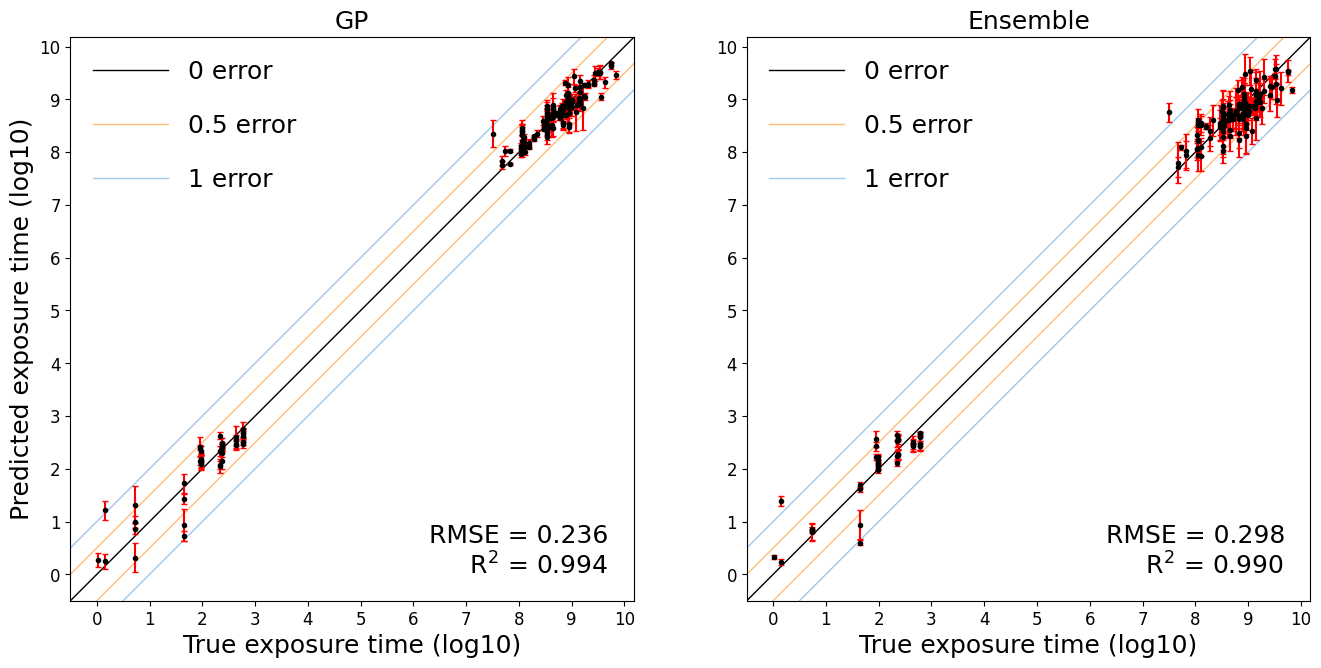

In [166]:
gp_actual = final_results_per_id['y_true']
gp_predicted = final_results_per_id['y_pred_average']
gp_std = final_results_per_id['standard_deviation']

cnn_tree_actual = ensemble_cnn_df['Actual']
cnn_tree_predicted = ensemble_cnn_df['Predicted']
cnn_tree_std = ensemble_cnn_df['STD']

true_line = pd.Series([-1, 12])
interval1 = true_line-1
interval2 = true_line-0.5
interval3 = true_line+0.5
interval4 = true_line+1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.plot(true_line, true_line, color='black', linestyle='-', linewidth=1, label='0 error')
ax1.plot(true_line, interval2, color='#FFBC79', linestyle='-', linewidth=1, label='0.5 error')
ax1.plot(true_line, interval1, color='#A2C8EC', linestyle='-', linewidth=1, label='1 error')
ax1.plot(true_line, interval3, color='#FFBC79', linestyle='-', linewidth=1)
ax1.plot(true_line, interval4, color='#A2C8EC', linestyle='-', linewidth=1)
ax1.errorbar(gp_actual, gp_predicted, yerr=[gp_std, gp_std], capsize=2, fmt='.', color='black', ecolor='red', alpha=1)
ax1.set_xlim(-0.5, max(gp_predicted) + 0.5)
ax1.set_ylim(-0.5, max(gp_predicted) + 0.5)
ax1.set_xticks(np.arange(0, max(y_test)+1.1, 1))
ax1.set_yticks(np.arange(0, max(y_test)+1.1, 1))
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=12)
ax1.set_xlabel('True exposure time (log10)', fontsize=18)
ax1.set_ylabel('Predicted exposure time (log10)', fontsize=18)
ax1.set_title('GP', fontsize=18)
ax1.legend(
	fontsize=18,  # Font size
	loc='upper left',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
ax1.text(
	8, 0,  # Position of the text box
	f'RMSE = {gp_RMSE:.3f}\n     R$^2$ = {gp_R2:.3f}', # Text
	fontsize=18,  # Font size
	bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'),  # Box properties
	ha='center'
)
ax1.set_aspect('equal', adjustable='box')

ax2.plot(true_line, true_line, color='black', linestyle='-', linewidth=1, label='0 error')
ax2.plot(true_line, interval2, color='#FFBC79', linestyle='-', linewidth=1, label='0.5 error')
ax2.plot(true_line, interval1, color='#A2C8EC', linestyle='-', linewidth=1, label='1 error')
ax2.plot(true_line, interval3, color='#FFBC79', linestyle='-', linewidth=1)
ax2.plot(true_line, interval4, color='#A2C8EC', linestyle='-', linewidth=1)
ax2.errorbar(cnn_tree_actual, cnn_tree_predicted, yerr=[cnn_tree_std, cnn_tree_std], capsize=2, fmt='.', color='black', ecolor='red', alpha=1)
ax2.set_xlim(-0.5, max(gp_predicted) + 0.5)
ax2.set_ylim(-0.5, max(gp_predicted) + 0.5)
ax2.set_xticks(np.arange(0, max(y_test)+1.1, 1))
ax2.set_yticks(np.arange(0, max(y_test)+1.1, 1))
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)
ax2.set_xlabel('True exposure time (log10)', fontsize=18)
# ax2.set_ylabel('Predicted exposure time (log10)', fontsize=18)
ax2.set_title('Ensemble', fontsize=18)
ax2.legend(
	fontsize=18,  # Font size
	loc='upper left',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
ax2.text(
	8, 0,  # Position of the text box
	f'RMSE = {ensemble_RMSE:.3f}\n     R$^2$ = {ensemble_R2:.3f}', # Text
	fontsize=18,  # Font size
	bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'),  # Box properties
	ha='center'
)
ax2.set_aspect('equal', adjustable='box')

# plt.tight_layout()
plt.show()